In [1]:
pip install pandas_datareader

     -------------------------------------- 109.5/109.5 kB 3.1 MB/s eta 0:00:00
     ---------------------------------------- 3.6/3.6 MB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install torch

     -------------------------------------- 161.9/161.9 MB 5.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [37]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

<AxesSubplot:xlabel='Date'>

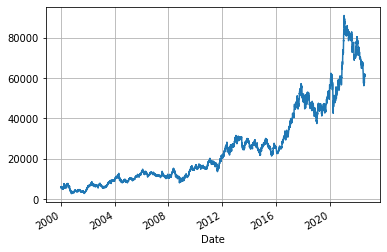

In [38]:
start = (2000, 1, 1)  # 2020년 01년 01월 
start = datetime.datetime(*start)  
end = datetime.date.today()  # 현재 

# yahoo 에서 삼성 전자 불러오기 
df = pdr.DataReader('005930.KS', 'yahoo', start, end)
df.head(5)
df.tail(5)
df.Close.plot(grid=True)

In [39]:
X = df.drop(columns='Volume')
y = df.iloc[:, 5:6]

print(X)
print(y)

               High      Low     Open    Close     Adj Close
Date                                                        
2000-01-04   6110.0   5660.0   6000.0   6110.0   4623.465820
2000-01-05   6060.0   5520.0   5800.0   5580.0   4222.414551
2000-01-06   5780.0   5580.0   5750.0   5620.0   4252.681152
2000-01-07   5670.0   5360.0   5560.0   5540.0   4192.144043
2000-01-10   5770.0   5580.0   5600.0   5770.0   4366.187012
...             ...      ...      ...      ...           ...
2022-08-01  61700.0  60300.0  61000.0  61300.0  61300.000000
2022-08-02  61900.0  61000.0  61200.0  61700.0  61700.000000
2022-08-03  61600.0  61000.0  61600.0  61300.0  61300.000000
2022-08-04  61800.0  61200.0  61700.0  61500.0  61500.000000
2022-08-05  61900.0  61200.0  61700.0  61500.0  61500.000000

[5673 rows x 5 columns]
               Adj Close
Date                    
2000-01-04   4623.465820
2000-01-05   4222.414551
2000-01-06   4252.681152
2000-01-07   4192.144043
2000-01-10   4366.187012
...    

In [40]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
mm = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 

# Train Data
X_train = X_ss[:4500, :]
X_test = X_ss[4500:, :]

# Test Data 

y_train = y_mm[:4500, :]
y_test = y_mm[4500:, :] 

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape) 


Training Shape (4500, 5) (4500, 1)
Testing Shape (1173, 5) (1173, 1)


In [41]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([4500, 1, 5]) torch.Size([4500, 1])
Testing Shape torch.Size([1173, 1, 5]) torch.Size([1173, 1])


In [42]:
class LSTM1(nn.Module):
    
    
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU() 

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state   
        # Propagate input through LSTM

        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state

        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output

        return out 

In [54]:
num_epochs = 30000 #1000 epochs
learning_rate = 0.00001 #0.001 lr

input_size = 5 
hidden_size = 2 
num_layers = 1 

num_classes = 1 

In [55]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 


In [56]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

loss_function = torch.nn.MSELoss()    
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  

In [57]:
for epoch in range(num_epochs):
    outputs = lstm1.forward(X_train_tensors_final.to(device)) 
    optimizer.zero_grad() 
    
    loss = loss_function(outputs, y_train_tensors.to(device))

    loss.backward() 
 
    optimizer.step() 
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

Epoch: 0, loss: 0.03954
Epoch: 100, loss: 0.03105
Epoch: 200, loss: 0.02436
Epoch: 300, loss: 0.01922
Epoch: 400, loss: 0.01538
Epoch: 500, loss: 0.01259
Epoch: 600, loss: 0.01064
Epoch: 700, loss: 0.00930
Epoch: 800, loss: 0.00843
Epoch: 900, loss: 0.00786
Epoch: 1000, loss: 0.00751
Epoch: 1100, loss: 0.00727
Epoch: 1200, loss: 0.00711
Epoch: 1300, loss: 0.00699
Epoch: 1400, loss: 0.00688
Epoch: 1500, loss: 0.00679
Epoch: 1600, loss: 0.00669
Epoch: 1700, loss: 0.00659
Epoch: 1800, loss: 0.00649
Epoch: 1900, loss: 0.00639
Epoch: 2000, loss: 0.00629
Epoch: 2100, loss: 0.00618
Epoch: 2200, loss: 0.00608
Epoch: 2300, loss: 0.00597
Epoch: 2400, loss: 0.00586
Epoch: 2500, loss: 0.00575
Epoch: 2600, loss: 0.00564
Epoch: 2700, loss: 0.00553
Epoch: 2800, loss: 0.00541
Epoch: 2900, loss: 0.00529
Epoch: 3000, loss: 0.00517
Epoch: 3100, loss: 0.00505
Epoch: 3200, loss: 0.00493
Epoch: 3300, loss: 0.00481
Epoch: 3400, loss: 0.00469
Epoch: 3500, loss: 0.00457
Epoch: 3600, loss: 0.00446
Epoch: 3700, 

Epoch: 29700, loss: 0.00000
Epoch: 29800, loss: 0.00000
Epoch: 29900, loss: 0.00000


In [58]:
df_X_ss = ss.transform(df.drop(columns='Volume'))
df_y_mm = mm.transform(df.iloc[:, 5:6])

df_X_ss = Variable(torch.Tensor(df_X_ss)) 
df_y_mm = Variable(torch.Tensor(df_y_mm))
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))

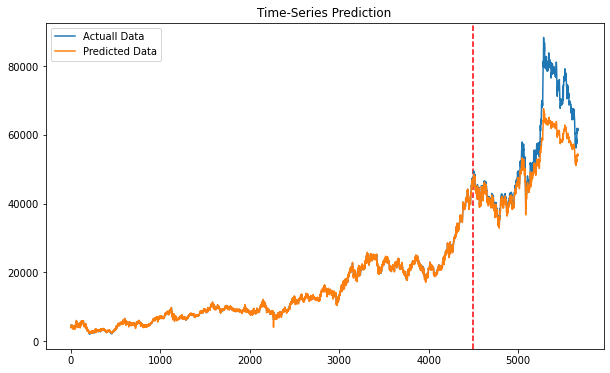

In [59]:
train_predict = lstm1(df_X_ss.to(device))
data_predict = train_predict.data.detach().cpu().numpy() 
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) 
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) 
plt.axvline(x=4500, c='r', linestyle='--') 

plt.plot(dataY_plot, label='Actuall Data') 
plt.plot(data_predict, label='Predicted Data') 
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 